# Connect to gg drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/lab/

/content/drive/MyDrive/lab


In [ ]:
!pip install transformers

In [ ]:
!nvidia-smi

Sat Oct 14 02:05:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import package

In [ ]:
import pandas as pd
import os
import collections
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [ ]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [ ]:
os.listdir(os.getcwd()+'/Wisdomnet/Untitled Folder')

['y_test.csv',
 'y_val.csv',
 'misclassified-data.csv',
 'y_train.csv',
 'X_val.csv',
 'X_train.csv',
 'X_test.csv',
 'misclassified-outdate.csv']

# Read data

In [ ]:
data_folder = os.getcwd()+'/Wisdomnet/Untitled Folder/'

# def extract_file():
#   file_zip = os.getcwd() + '/Data_Cleansing.zip'
#   with zipfile.ZipFile(file_zip, 'r') as zip_ref:
#     zip_ref.extractall(path=data_folder)

# extract_file()

In [ ]:
# data = pd.read_csv(data_folder + '/Data_Cleansing_a.csv')

In [ ]:
labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']

In [ ]:
X_train = pd.read_csv(data_folder+'X_train.csv').to_numpy()
X_test = pd.read_csv(data_folder+'X_test.csv').to_numpy()
X_val = pd.read_csv(data_folder+'X_val.csv').to_numpy()

y_train = pd.read_csv(data_folder+'y_train.csv').to_numpy()
y_test = pd.read_csv(data_folder+'y_test.csv').to_numpy()
y_val = pd.read_csv(data_folder+'y_val.csv').to_numpy()

# Define Constant

In [ ]:
# Defining some key variables that will be used later on in the training
max_length = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-04
num_class = 4

# Define Model

## Load pretrained model form huggingface

In [ ]:
from transformers import BertModel, BertTokenizerFast

secBertTokenizer = BertTokenizerFast.from_pretrained("jackaduma/SecBERT", do_lower_case=True)
secBertModel = BertModel.from_pretrained("jackaduma/SecBERT", num_labels = num_class)

In [ ]:
secBertModel

In [ ]:
def freeze_k_layer(secBert, k=1):
  for param in secBert.encoder.layer[0:k].parameters():
    param.requires_grad = False

In [ ]:
freeze_k_layer(secBertModel, k=6)

## Create Custom Model

In [ ]:
class Branch(nn.Module):
  def __init__(self, input_size, hidden1_size, hidden2_size, dropout, num_outputs):
    super(Branch, self).__init__()

    self.dense1 = nn.Linear(input_size, hidden1_size)
    self.dropout = nn.Dropout(p=dropout)
    self.dense2 = nn.Linear(hidden1_size, hidden2_size)
    self.dense3 = nn.Linear(hidden2_size, num_outputs)

  def forward(self, x):
    out_dense1 = self.dense1(x)
    out_dropout = self.dropout(out_dense1)
    out_dense2 = self.dense2(out_dropout)
    out_dense3 = self.dense3(out_dense2)

    return out_dense3

### SecBert-Escort

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(BaseModel, self).__init__()
        self.num_classes = num_classes
        self.original_model = original_model
        self.branches = nn.ModuleList([Branch(768, 128, 64, 0.1, 2) for _ in range(num_classes)])
        self.activation = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        out_bert = self.original_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler_out = out_bert.pooler_output
        output_branches = [branch(pooler_out) for branch in self.branches]
        # outputs = [self.activation(out_branch) for out_branch in output_branches]

        # apply softmax function for each branch
        out_soft = [self.activation(out) for out in output_branches]
        out_soft_max_indices = [torch.argmax(out, dim=1) for out in out_soft]
        out_soft_max_indices = torch.stack(out_soft_max_indices, dim=1)

        return out_soft, out_soft_max_indices

secBertClassifierMultilabel = BaseModel(original_model=secBertModel, num_classes=num_class)

### WisdomNet Model

In [ ]:
class WisdomNet(nn.Module):
  def __init__(self, trained_model):
    super(WisdomNet, self).__init__()
    self.numclasses = trained_model.num_classes
    self.bert = trained_model.original_model

    num_outputs = 3 # add a reject label --> num_outputs = old_outputs + 1
    self.new_branches = nn.ModuleList([Branch(768, 128, 64, 0.1, num_outputs) for _ in range(self.numclasses)])

    for i in range(self.numclasses):
      old_branch = trained_model.branches[i]
      new_branch = self.new_branches[i]
      self.copy_weight_branch(old_branch, new_branch)
      new_branch.dense3.weight.data[:2].copy_(old_branch.dense3.weight.data.clone())
      new_branch.dense3.bias.data[:2].copy_(old_branch.dense3.bias.data.clone())

    self.softmax = nn.Softmax(dim=1)

  def copy_weight_branch(self, old_branch, new_branch, name_except='dense3'):
    for name, param in old_branch.named_parameters():
      if name_except not in name:
        name_layer = name.split('.')[0]
        name_attr_layer = name.split('.')[1]
        new_model_param = getattr(new_branch, name_layer)
        if name_attr_layer == 'weight':
          new_model_param.weight.data.copy_(param.data.clone())
        if name_attr_layer == 'bias':
          new_model_param.bias.data.copy_(param.data.clone())

  def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
    out_bert = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooler_out = out_bert.pooler_output
    output_branches = [branch(pooler_out) for branch in self.new_branches]

    # apply softmax function for each branch
    out_soft = [self.softmax(out) for out in output_branches]
    out_soft_max_indices = [torch.argmax(out, dim=1) for out in out_soft]
    out_soft_max_indices = torch.stack(out_soft_max_indices, dim=1)

    return out_soft, out_soft_max_indices

In [ ]:
# print(torch.equal(test_branch.dense1.weight, old_branch.dense1.weight))
# print(torch.equal(test_branch.dense1.bias, old_branch.dense1.bias))

# print(torch.equal(test_branch.dense2.weight, old_branch.dense2.weight))
# print(torch.equal(test_branch.dense2.bias, old_branch.dense2.bias))

# print(torch.equal(test_branch.dense3.weight, old_branch.dense3.weight))
# print(torch.equal(test_branch.dense3.bias, old_branch.dense3.bias))

# Preprocess data

## Define Dataset

In [ ]:
class OpcodeData(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.X = X
        self.targets = y
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        text = str(self.X[index])

        inputs = self.tokenizer(
            text,
            None,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'index': index,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

training_set = OpcodeData(X_train, y_train, secBertTokenizer, max_length)
validating_set = OpcodeData(X_val, y_val, secBertTokenizer, max_length)
testing_set = OpcodeData(X_test, y_test, secBertTokenizer, max_length)

In [ ]:
train_params = {
  'batch_size': TRAIN_BATCH_SIZE,
  'shuffle': True,
  'num_workers': 0
}

val_params = {
  'batch_size': VALID_BATCH_SIZE,
  'shuffle': True,
  'num_workers': 0
}

test_params = {
  'batch_size': VALID_BATCH_SIZE,
  'shuffle': False,
  'num_workers': 0
}

# Create generator for Dataset with BATCH_SIZE
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE)
validating_loader = DataLoader(validating_set, batch_size=VALID_BATCH_SIZE)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE)

In [ ]:
# inputs = next(iter(training_loader))
# ids = inputs['ids']
# index = inputs['index']
# print(ids.shape)
# ids = inputs['ids'].to(device)
# mask = inputs['mask'].to(device)
# token_type_ids = inputs['token_type_ids'].to(device)
# targets = inputs['targets'].to(device)
# secBertClassifierMultilabel.to(device)

# Define Metrics and Save the result

In [ ]:
def calculate_score(y_true, preds, score_type=''):
  acc_score = 0.0
  if score_type=='multioutput':
    num_acc = 0
    for i in range(len(y_true)):
      if np.array_equal(y_true[i], preds[i]):
        num_acc+=1
    acc_score = num_acc / len(y_true)
  else:
    acc_score = accuracy_score(y_true, preds)

  return acc_score

In [ ]:
def save_classification(y_test, y_pred, out_dir, labels):
  if isinstance(y_pred, np.ndarray) == False:
    y_pred = y_pred.toarray()

  def accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        numerator = sum(np.logical_and(y_true[i], y_pred[i]))
        denominator = sum(np.logical_or(y_true[i], y_pred[i]))
        if denominator != 0:
          temp += numerator / denominator
    return temp / y_true.shape[0]

  out = classification_report(y_test,y_pred, output_dict=True, target_names=labels)
  total_support = out['samples avg']['support']

  mr = accuracy_score(y_test, y_pred)
  acc = accuracy(y_test,y_pred)
  hm = hamming_loss(y_test, y_pred)

  out['Exact Match Ratio'] = {'precision': mr, 'recall': mr, 'f1-score': mr, 'support': total_support}
  out['Hamming Loss'] = {'precision': hm, 'recall': hm, 'f1-score': hm, 'support': total_support}
  out['Accuracy'] = {'precision': acc, 'recall': acc, 'f1-score': acc, 'support': total_support}
  out_df = pd.DataFrame(out).transpose()
  print(out_df)

  out_df.to_csv(out_dir)

  return out_df

In [ ]:
def wisdomnet_cfm(y_true, y_pred, reject_label=2):

  if y_true.shape[0] != y_pred.shape[0] or y_true.shape[1] != y_pred.shape[1]:
    return Exception("Shape is not equally")

  num_samples = y_true.shape[0]
  num_label = y_true.shape[1]
  cfm = np.zeros(shape=(num_label, 2, 3), dtype=int)

  for i in range(num_label):
    num_reject = 0
    TN, FN, TP, FP = 0, 0, 0, 0
    for j in range(num_samples):
      if y_pred[j][i] == reject_label:
        num_reject+=1
      elif y_true[j][i] == 1 and y_pred[j][i] == 1:
        TP += 1  # True Positive
      elif y_true[j][i] == 0 and y_pred[j][i] == 1:
        FP += 1  # False Positive
      elif y_true[j][i] == 0 and y_pred[j][i] == 0:
        TN += 1  # True Negative
      elif y_true[j][i] == 1 and y_pred[j][i] == 0:
        FN += 1  # False Negative

    cfm[i, 0, 0] = TN
    cfm[i, 1, 0] = FN
    cfm[i, 1, 1] = TP
    cfm[i, 0, 1] = FP
    cfm[i, 0, 2] = num_reject
    cfm[i, 1, 2] = num_reject

  return cfm

def calculate_accuracy(y_true, y_pred):
  if y_true.shape[0] != y_pred.shape[0] or y_true.shape[1] != y_pred.shape[1]:
    return Exception("Shape is not equally")

  num_samples = y_true.shape[0]
  num_labels = y_true.shape[1]
  acc_score = 0.

  for i in range(num_samples):
    num_acc = 0
    total = 0
    for j in range(num_labels):
      if y_true[i, j] == y_pred[i, j] and y_true[i, j] != 0:
        num_acc+=1

      if y_true[i, j] != 0 or y_pred[i, j] != 0:
        total += 1
    acc_score += num_acc / total
  return acc_score / num_samples

def my_classification_report(y_true, y_pred, labels):
  cfm = wisdomnet_cfm(y_true, y_pred)
  num_labels = len(labels)
  sum_all_TP, sum_all_FP, sum_all_FN = 0, 0, 0
  sum_pre, sum_re, sum_f1 = 0., 0., 0.

  report = {}

  for i in range(num_labels):
    TN = cfm[i, 0, 0]
    FN = cfm[i, 1, 0]
    TP = cfm[i, 1, 1]
    FP = cfm[i, 0, 1]
    reject_labels = cfm[i, 0, 2]

    label = labels[i]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)

    sum_pre += precision
    sum_re += recall
    sum_f1 += F1

    sum_all_TP += TP
    sum_all_FP += FP
    sum_all_FN += FN

    report[label] = {
        'Precision': precision,
        'Recall': recall,
        'F1': F1,
        'Reject Label': reject_labels
    }

  micro_p = sum_all_TP / (sum_all_TP + sum_all_FP)
  micro_r = sum_all_TP / (sum_all_TP + sum_all_FN)
  micro_f = (2 * micro_p * micro_r) / (micro_r + micro_p)

  report['micro avg'] = {
    'Precision': micro_p,
    'Recall': micro_r,
    'F1': micro_f,
    'Reject Label': 0
  }

  report['macro avg'] = {
    'Precision': sum_pre / num_labels,
    'Recall': sum_re / num_labels,
    'F1': sum_f1 / num_labels,
    'Reject Label': 0
  }

  acc = calculate_accuracy(y_true, y_pred)
  report['accuracy'] = {
    'Precision': acc,
    'Recall': acc,
    'F1': acc,
    'Reject Label': 0
  }

  df = pd.DataFrame(report).T
  df.columns = ['Precision', 'Recall', 'F1', 'Reject Label']

  return df

In [ ]:
def get_misclassified_data(labels, preds, indices):
  misclassify_data = {}
  for i in range(len(labels)):
    is_append = False
    reject_label = np.array(labels[i])
    for j in range(len(labels[i])):
      if labels[i, j] != preds[i, j]:
        reject_label[j] = 2 # reject label
        is_append = True

    if is_append:
      x_train_index = indices[i]
      misclassify_data[x_train_index] = np.array(reject_label)
  return misclassify_data

In [ ]:
# labels = np.array([[1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 0, 1, 1]])
# preds = np.array([[1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 0, 0], [1, 0, 1, 1]])

# print(get_misclassified_data(labels, preds))
# print(labels)
# print(preds)

In [ ]:
# misclassify_data = {}

# misclassify_data[0] = np.array([1, 0, 1, 1])
# misclassify_data[0] = np.array([1, 1, 1, 1])
# misclassify_data

# Define Training Fuction

## Train Steps

In [ ]:
def train_steps(training_loader, model, loss_f, optimizer, score_type='', is_find_miss=True):
    print('Training...')
    training_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    train_acc = 0.
    train_f1 = 0.
    misclassify_train_data = {}

    model.train()

    for step, batch in enumerate(training_loader):
        # push the batch to gpu
        indices = batch['index'].numpy()
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # calculate the loss for each branch
        losses = [loss_f(preds[i], targets[:, i]) for i in range(targets.shape[1])]
        average_loss = sum(losses) / targets.shape[1]
        training_loss += average_loss.item()

        label_ids = targets.to('cpu').numpy()
        max_indices = max_indices.detach().cpu().numpy()
        acc_score = calculate_score(label_ids, max_indices, score_type)
        train_acc += acc_score

        if is_find_miss:
          misclassify_data = get_misclassified_data(label_ids, max_indices, indices)
          misclassify_train_data.update(misclassify_data)

        nb_tr_steps += 1

        optimizer.zero_grad()
        average_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # When using GPU
        optimizer.step()

    epoch_loss = training_loss / nb_tr_steps
    epoch_acc = train_acc / nb_tr_steps

    return epoch_loss, epoch_acc, misclassify_train_data

## Evaluation Steps

In [ ]:
def evaluate_steps(validating_loader, model, loss_f, score_type='', **kwargs):
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step, batch in enumerate(validating_loader):
        # push the batch to gpu
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

            # compute the validation loss between actual and predicted values
            losses = [loss_f(preds[i], targets[:, i]) for i in range(targets.shape[1])]
            average_loss = sum(losses) / targets.shape[1]
            total_loss += average_loss.item()

            max_indices = max_indices.detach().cpu().numpy()
            total_preds += list(max_indices)
            total_labels += targets.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(validating_loader)
    acc_score = calculate_score(total_labels, total_preds, score_type)

    return avg_loss, acc_score

## Train Loop

In [ ]:
def train(epochs, model, optimizer, criterion, dataloader, score_type='', save_dir='secbert-escort.pt', is_find_miss=True):
  data_train_loader, data_val_loader = dataloader
  # set initial loss to infinite
  best_valid_loss = float('inf')
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  misclassify_train_data = {}

  for epoch in range(epochs):
    print('Epoch {}/{} '.format(epoch + 1, epochs))
    start_time = time.time()
    train_loss, train_acc, misclassify_train_steps_data = train_steps(data_train_loader, model, criterion, optimizer, score_type=score_type, is_find_miss=is_find_miss)
    valid_loss, valid_acc = evaluate_steps(data_val_loader, model, criterion, score_type=score_type)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_dir)
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    misclassify_train_data.update(misclassify_train_steps_data)

    elapsed_time = time.time() - start_time

    print('\t loss={:.4f} \t accuracy={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(train_loss, train_acc, valid_loss, valid_acc, elapsed_time))

  return train_accuracies, valid_accuracies, train_losses, valid_losses, misclassify_train_data

## Predict

In [ ]:
def predict(testing_loader, model):
    print("\nPredicting...")
    # deactivate dropout layers
    model.eval()

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step, batch in enumerate(testing_loader):
        # push the batch to gpu
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

            max_indices = max_indices.detach().cpu().numpy()
            total_preds += list(max_indices)
            total_labels += targets.tolist()

    return total_labels, total_preds

## Draw the graph

In [ ]:
def plot_graph(epochs, train, valid, tittle):
    fig = plt.figure(figsize=(12,12))
    plt.title(tittle)
    plt.plot(list(np.arange(epochs) + 1) , train, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

# Run model

## Train SecBert-Escort model

In [ ]:
secBertClassifierMultilabel.to(device)

# Creating the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = secBertClassifierMultilabel.parameters(), lr=LEARNING_RATE)

train_accuracies, valid_accuracies, train_losses, valid_losses, misclassify_train_data = train(EPOCHS, secBertClassifierMultilabel, optimizer, criterion, (training_loader, validating_loader))
df = pd.DataFrame.from_dict(misclassify_train_data, orient='index', columns=labels)
df.index.name = 'X_train_index'
df.to_csv(data_folder+'misclassified-data.csv')

"""
Plot the result of training process
"""
plot_graph(EPOCHS, train_losses, valid_losses, "Train/Validation Loss")
plot_graph(EPOCHS, train_accuracies, valid_accuracies, "Train/Validation Accuracy")

"""
Evaluate model on test set and save the result
"""
total_labels, total_preds = predict(testing_loader, secBertClassifierMultilabel)
df_labels = pd.DataFrame(total_labels, columns=labels)
df_preds = pd.DataFrame(total_preds, columns=labels)

df_labels.to_csv(data_folder+'labels-test-secbert-escort.csv')
df_preds.to_csv(data_folder+'preds-secbert-escort.csv')

save_classification(y_test=np.array(total_labels), y_pred=np.array(total_preds), labels=labels, out_dir='escort-secbert.csv')

## Train wisdomnet Model

In [ ]:
def train_wisdomnet(frac_mis=0.01):
  secBertClassifierMultilabel.load_state_dict(torch.load('/kaggle/working/secbert-escort.pt'))

  wisdomnet = WisdomNet(secBertClassifierMultilabel)
  wisdomnet.to(device)

  # data = pd.read_csv(data_folder + '/Data_Cleansing_a.csv')
  misclassified_df = pd.read_csv('/kaggle/working/misclassified-data.csv')
  misclassified_df.sample(frac=frac_mis, replace=True, randome_state=2023)
  X_m_index = misclassified_df['X_train_index'].to_list()
  X_train = pd.read_csv('/kaggle/input/opcode/X_train.csv')

  X_m, y_m = X_train.iloc[X_m_index].to_numpy(), misclassified_df.iloc[:, -4:].to_numpy()
  X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.2, random_state=2023)
  X_m_train, X_m_val, y_m_train, y_m_val = train_test_split(X_m_train, y_m_train, test_size=0.2, random_state=2023)

  training_m_set = OpcodeData(X_m_train, y_m_train, secBertTokenizer, max_length)
  validating_m_set = OpcodeData(X_m_val, y_m_val, secBertTokenizer, max_length)
  testing_m_set = OpcodeData(X_m_test, y_m_test, secBertTokenizer, max_length)

  # Create generator for Dataset with BATCH_SIZE
  training_m_loader = DataLoader(training_m_set, batch_size=TRAIN_BATCH_SIZE)
  validating_m_loader = DataLoader(validating_m_set, batch_size=VALID_BATCH_SIZE)
  testing_m_loader = DataLoader(testing_m_set, batch_size=VALID_BATCH_SIZE)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params = wisdomnet.parameters(), lr=LEARNING_RATE)

  train_m_accuracies, valid_m_accuracies, train_m_losses, valid_m_losses, _ =
  train(EPOCHS, wisdomnet, optimizer, criterion, (training_loader, validating_loader), score_type='multioutput', save_dir='wisdomnet-escort'+(frac_mis*100)+'-percent.pt', is_find_miss=False)

  """
  Plot the result of training process
  """
  plot_graph(EPOCHS, train_m_losses, valid_m_losses, "Train/Validation Loss")
  plot_graph(EPOCHS, train_m_accuracies, valid_m_accuracies, "Train/Validation Accuracy")

  """
  Evaluate model on test set and save the result
  """
  labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
  start = time.time()
  total_labels, total_preds = predict(testing_loader, wisdomnet)
  end = time.time()

  execution_time = (end - start) / len(total_labels)
  print('Execution time: ', execution_time)
  df_labels = pd.DataFrame(total_labels, columns=labels)
  df_preds = pd.DataFrame(total_preds, columns=labels)

  mycr = my_classification_report(df_labels.to_numpy(), df_preds.to_numpy(), labels)
  mycr
  print(mycr)

  df_labels.to_csv('/kaggle/working/labels-test-wisdomnet'+(frac_mis*100)+'-percent.csv')
  df_preds.to_csv('/kaggle/working/preds-wisdomnet'+(frac_mis*100)+'-percent.csv')

In [ ]:
secBertClassifierMultilabel.load_state_dict(torch.load(os.getcwd()+'/trained (1)/secbert-escort.pt'))

<All keys matched successfully>

In [ ]:
wisdomnet = WisdomNet(secBertClassifierMultilabel)
wisdomnet.to(device)

In [ ]:
# data = pd.read_csv(data_folder + '/Data_Cleansing_a.csv')
data_folder = os.getcwd() + '/data-multilabel/'
misclassified_df = pd.read_csv(data_folder+'misclassified-data.csv')
X_m_index = misclassified_df['X_train_index'].to_list()
X_train = pd.read_csv(data_folder+'X_train.csv')

X_m, y_m = X_train.iloc[X_m_index].to_numpy(), misclassified_df.iloc[:, -4:].to_numpy()
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.2, random_state=2023)
X_m_train, X_m_val, y_m_train, y_m_val = train_test_split(X_m_train, y_m_train, test_size=0.2, random_state=2023)

In [ ]:
print(X_m.shape, y_m.shape)

(3669, 1) (3669, 4)


In [ ]:
training_m_set = OpcodeData(X_m_train, y_m_train, secBertTokenizer, max_length)
validating_m_set = OpcodeData(X_m_val, y_m_val, secBertTokenizer, max_length)
testing_m_set = OpcodeData(X_m_test, y_m_test, secBertTokenizer, max_length)

# Create generator for Dataset with BATCH_SIZE
training_loader = DataLoader(training_m_set, batch_size=TRAIN_BATCH_SIZE)
validating_loader = DataLoader(validating_m_set, batch_size=VALID_BATCH_SIZE)
testing_loader = DataLoader(testing_m_set, batch_size=VALID_BATCH_SIZE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = wisdomnet.parameters(), lr=LEARNING_RATE)

train_m_accuracies, valid_m_accuracies, train_m_losses, valid_m_losses, _ =
train(EPOCHS, wisdomnet, optimizer, criterion,
 (training_loader, validating_loader), score_type='multioutput', 'wisdomnet-escort.pt', is_find_miss=False)

In [ ]:
"""
Plot the result of training process
"""
plot_graph(EPOCHS, train_m_losses, valid_m_losses, "Train/Validation Loss")
plot_graph(EPOCHS, train_m_accuracies, valid_m_accuracies, "Train/Validation Accuracy")

In [ ]:
"""
Evaluate model on test set and save the result
"""
labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
total_labels, total_preds = predict(testing_loader, wisdomnet)
df_labels = pd.DataFrame(total_labels, columns=labels)
df_preds = pd.DataFrame(total_preds, columns=labels)

df_labels.to_csv(data_folder+'labels-test-wisdomnet.csv')
df_preds.to_csv(data_folder+'preds-wisdomnet.csv')


Predicting...


In [ ]:
y_true = pd.read_csv(data_folder+'labels-test-wisdomnet.csv')
y_pred = pd.read_csv(data_folder+'preds-wisdomnet.csv')

y_true = y_true.iloc[:, -4:]
y_pred = y_pred.iloc[:, -4:]
labels = y_true.columns.to_list()

In [ ]:
classification_report(y_true,y_pred, target_names=labels)

### Misclassified Analysis

In [ ]:
misclassified_df = pd.read_csv(os.getcwd()+'/misclassified-data.csv')

In [ ]:
misclassified_df.head()

,X_train_index,Timestamp dependence,Outdated Solidity version,Frozen Ether,Delegatecall Injection
0,0,0,2,1,2
1,2,0,2,1,1
2,3,0,1,2,2
3,4,2,1,0,2
4,5,0,2,1,1


In [ ]:
len(misclassified_df)

3669

In [ ]:
type(misclassified_df['Timestamp dependence'].value_counts())

pandas.core.series.Series

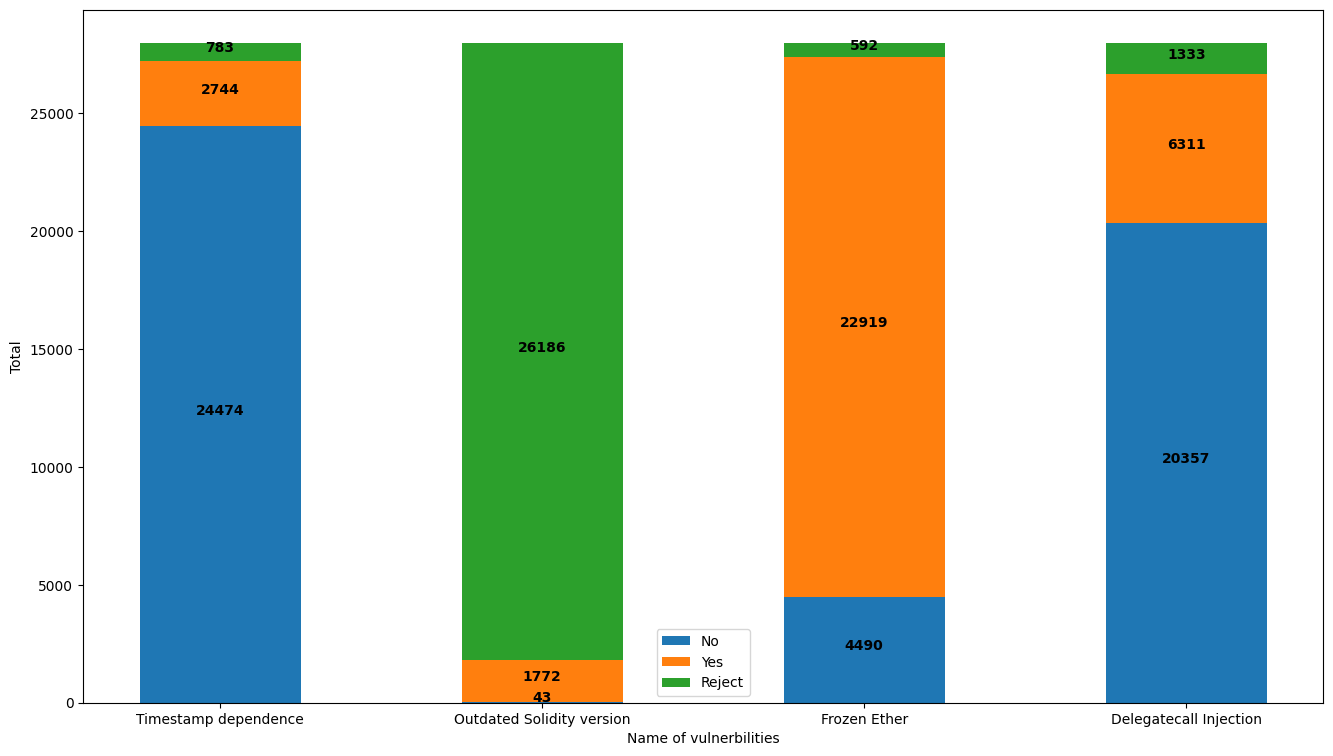

In [ ]:
values = []
labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
for i in labels:
  value_counts = misclassified_df[i].value_counts().to_dict()
  no_0 = value_counts[0]
  no_1 = value_counts[1]
  no_2 = value_counts[2]

  values.append([no_0, no_1, no_2])

values = np.array(values).T
values.shape[0]

# Plot
fig, ax = plt.subplots(figsize=(16, 9))
name = ['No', 'Yes', 'Reject']
# Stacked bar chart
for i in range(values.shape[0]):
  ax.bar(labels, values[i], bottom = np.sum(values[:i], axis = 0), width = 0.5, label = str(name[i]))

for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height()), ha = 'center',
          color = 'black', weight = 'bold', size = 10)

plt.legend()
ax.set_ylabel('Total')
ax.set_xlabel('Name of vulnerbilities')
plt.show()

In [ ]:
misclassified_df.to_numpy()

array([[    0,     0,     2,     1,     0],
       [    1,     0,     2,     1,     0],
       [    2,     0,     2,     1,     0],
       ...,
       [11515,     0,     2,     1,     0],
       [12142,     0,     2,     1,     0],
       [12188,     0,     2,     1,     0]])

In [ ]:
num_reject_counts = misclassified_df.iloc[:, -4:].apply(lambda x: (x == 2).sum())
min_reject = num_reject_counts.min()
min_index = num_reject_counts.argmin()
min_label = num_reject_counts.index[min_index]

In [ ]:
columns = ['X_train_index', 'Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
df = pd.DataFrame(columns=columns)

for label in labels:
  df_filtered = misclassified_df.loc[misclassified_df[label] == 2, :]
  df = pd.concat([df, df_filtered[:50]])

In [ ]:
def get_mis_data(mis_data_df, frac=0.01):
  df = pd.DataFrame(columns=mis_data_df.columns)
  labels = mis_data_df.columns[-4:]
  reject_label = 2

  def find_min_reject(misclassified_df):
    num_reject_counts = misclassified_df.apply(lambda x: (x == 2).sum())
    min_num_reject = num_reject_counts.min()
    min_index = num_reject_counts.argmin()
    min_label = num_reject_counts.index[min_index]

    return min_label, min_num_reject

  min_label, min_num_reject = find_min_reject(misclassified_df.iloc[:, -4:])
  threshold = int(min_num_reject * frac)

  for label in labels:
    df_filtered = misclassified_df.loc[misclassified_df[label] == reject_label, :]
    df = pd.concat([df, df_filtered[:threshold]])

  return df

In [ ]:
df = get_mis_data(misclassified_df)

In [ ]:
for label in labels:
  print(df[label].value_counts())

2    10
0    10
Name: Timestamp dependence, dtype: int64
1    14
2     6
Name: Outdated Solidity version, dtype: int64
2    12
1     6
0     2
Name: Frozen Ether, dtype: int64
2    16
1     2
0     2
Name: Delegatecall Injection, dtype: int64


In [ ]:
def fin_min_reject(misclassified_df):
  num_reject_counts = misclassified_df.apply(lambda x: (x == 2).sum())
  min_num_reject = num_reject_counts.min()
  min_index = num_reject_counts.argmin()
  min_label = num_reject_counts.index[min_index]

  return min_label, min_num_reject

def is_equal_num_reject(misclassified_df):
  pass

def undersample_multilabel(misclassified_df, labels, reject_label=2):
  min_label, min_num_reject = find_min_reject(misclassified_df.iloc[:, -4:])
  min_reject_df = misclassified_df.loc[misclassified_df[min_label] == reject_label, :]
  balanced_reject_data = pd.DataFrame(min_reject_df)

  labels.remove(min_label)
  threshold = min_num_reject

  while(is_equal_num_reject(balanced_reject_data) == False)
    min_label, min_num_reject = find_min_reject(misclassified_df.iloc[:, -4:])




In [ ]:
min_reject_df = misclassified_df.loc[misclassified_df[min_label] == 2, :]
balanced_reject_data = pd.DataFrame(min_reject_df)

In [ ]:
labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
labels.remove(min_label)
for i in labels:
  num_reject = balanced_reject_data[i].value_counts().to_dict()[2]
  print(num_reject)


71
162
46


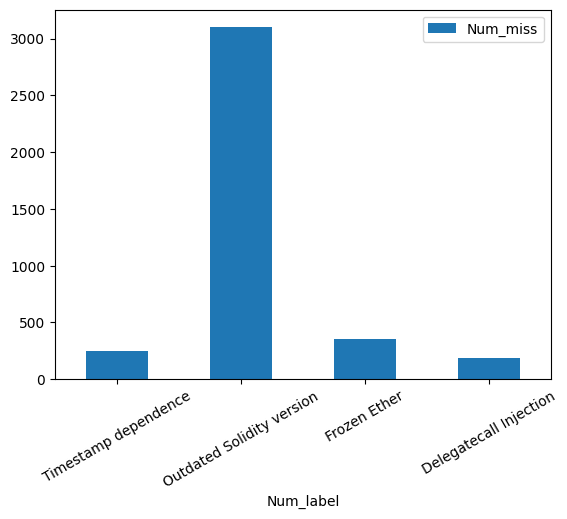

In [ ]:
num_miss_1 = misclassified_df['Timestamp dependence'].value_counts()[2].to_list()
num_miss_2 = misclassified_df['Outdated Solidity version'].value_counts()[2]
num_miss_3 = misclassified_df['Frozen Ether'].value_counts()[2]
num_miss_4 = misclassified_df['Delegatecall Injection'].value_counts()[2]

labels = ['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']
df = pd.DataFrame({'Num_label':labels, 'Num_miss':[num_miss_1, num_miss_2, num_miss_3, num_miss_4]})

ax = df.plot.bar(x='Num_label', y='Num_miss', rot=30)

In [ ]:
print(df['Num_miss'].sum())

3887


# Test Final Model

In [ ]:
X_test = pd.read_csv(data_folder+'X_test.csv').to_numpy()
y_test = pd.read_csv(data_folder+'y_test.csv').to_numpy()

In [ ]:
testing_set = OpcodeData(X_test, y_test, secBertTokenizer, max_length)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE)

In [ ]:
os.listdir(os.getcwd()+'/Wisdomnet/secbert-escort.pt')

['escort-secbert.gsheet',
 'Untitled Folder',
 'secbert-escort.pt',
 'Ket qua moi',
 'secbert-escort.ipynb',
 'test-wisdomnet.ipynb',
 'test_wisdomnet_outdated_label.ipynb']

## Test SecBERT - ESCORT

In [ ]:
# num_class = 4
# secBertClassifierMultilabel = BaseModel(original_model=secBertModel, num_classes=num_class)
secBertClassifierMultilabel.load_state_dict(torch.load(os.getcwd()+'/Wisdomnet/secbert-escort.pt'))
secBertClassifierMultilabel.to(device)
# wisdomnet = WisdomNet(secBertClassifierMultilabel)
# wisdomnet.load_state_dict(torch.load(os.getcwd()+'/trained (1)/wisdomnet-escort.pt'))
# wisdomnet.to(device)

BaseModel(
  (original_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
total_labels, total_preds = predict(testing_loader, secBertClassifierMultilabel)


Predicting...


In [ ]:
multilabel_confusion_matrix(y_true=np.array(total_labels), y_pred=np.array(total_preds))

array([[[23110,    32],
        [   55, 10770]],

       [[ 5678,  4450],
        [ 1633, 22206]],

       [[14351,     6],
        [  115, 19495]],

       [[26879,    30],
        [  296,  6762]]])

In [ ]:
# my_classification_report(np.array(total_labels), np.array(total_preds), labels)

In [ ]:
df_labels = pd.DataFrame(total_labels, columns=labels)
df_preds = pd.DataFrame(total_preds, columns=labels)

df_labels.to_csv(data_folder+'labels-test-final-model.csv')
df_preds.to_csv(data_folder+'preds-final-model.csv')

y_true = pd.read_csv(os.getcwd()+'/labels-test-final-model.csv').iloc[:, -4:]
y_pred = pd.read_csv(os.getcwd()+'/preds-final-model.csv').iloc[:, -4:]
labels=['Timestamp dependence', 'Outdated Solidity version', 'Frozen Ether', 'Delegatecall Injection']

wisdomnet_cfm(y_true.to_numpy(), y_pred.to_numpy())
my_classification_report(y_true.to_numpy(), y_pred.to_numpy(), labels)